<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notebook-Description" data-toc-modified-id="Notebook-Description-0.0.1">Notebook Description</a></span></li><li><span><a href="#Import-SBML-model" data-toc-modified-id="Import-SBML-model-0.0.2">Import SBML model</a></span></li><li><span><a href="#Construct-SymPy-Derivative-Matrix" data-toc-modified-id="Construct-SymPy-Derivative-Matrix-0.0.3">Construct SymPy Derivative Matrix</a></span><ul class="toc-item"><li><span><a href="#Automatically-Flag-Kinetic-Parameters" data-toc-modified-id="Automatically-Flag-Kinetic-Parameters-0.0.3.1">Automatically Flag Kinetic Parameters</a></span></li><li><span><a href="#Write-Derivative-Function" data-toc-modified-id="Write-Derivative-Function-0.0.3.2">Write Derivative Function</a></span></li><li><span><a href="#Initialize-Symbolic-Species-and-Parameter-Vectors" data-toc-modified-id="Initialize-Symbolic-Species-and-Parameter-Vectors-0.0.3.3">Initialize Symbolic Species and Parameter Vectors</a></span></li><li><span><a href="#Construct-Symbolic-Reactions-and-Stoichiometric-Matrix" data-toc-modified-id="Construct-Symbolic-Reactions-and-Stoichiometric-Matrix-0.0.3.4">Construct Symbolic Reactions and Stoichiometric Matrix</a></span></li><li><span><a href="#Assemble-symbolic-derivative-matrix" data-toc-modified-id="Assemble-symbolic-derivative-matrix-0.0.3.5">Assemble symbolic derivative matrix</a></span></li></ul></li><li><span><a href="#Construct-Nullspace-Matrix" data-toc-modified-id="Construct-Nullspace-Matrix-0.0.4">Construct Nullspace Matrix</a></span><ul class="toc-item"><li><span><a href="#Extract-Kinetic-Parameters" data-toc-modified-id="Extract-Kinetic-Parameters-0.0.4.1">Extract Kinetic Parameters</a></span></li><li><span><a href="#Obtain-Basis-for-Nullspace" data-toc-modified-id="Obtain-Basis-for-Nullspace-0.0.4.2">Obtain Basis for Nullspace</a></span></li><li><span><a href="#Construct-Nullspace-Matrix-from-Basis" data-toc-modified-id="Construct-Nullspace-Matrix-from-Basis-0.0.4.3">Construct Nullspace Matrix from Basis</a></span></li><li><span><a href="#Create-Anonymous-Sampling-Function" data-toc-modified-id="Create-Anonymous-Sampling-Function-0.0.4.4">Create Anonymous Sampling Function</a></span></li></ul></li><li><span><a href="#Performance-Comparison" data-toc-modified-id="Performance-Comparison-0.0.5">Performance Comparison</a></span></li><li><span><a href="#Notes" data-toc-modified-id="Notes-0.0.6">Notes</a></span></li></ul></li></ul></li></ul></div>

### Notebook Description

This notebook walks through an approach to generating a symbolic matrices from a custom `SciPyModel` class in Python for use in sampling and sensitivity analysis. This notebook will be the basis for implementing an extension of the functionality provided by the SBML2SciPy toolbox.

The focus of the testing is to implement a method for detecting whether a parameter should be flagged as kinetic or shape.

For the time being, the main assumption in formulation is that the kinetic parameters appear in the formulas as $k_A*f_A(y_1,...,y_n)$ in order to make it easier to identify and extract them.

### Import SBML model
Execute functions to convert SBML model to custom class.

In [51]:
from utils import SBML2SciPy
SciPyModel = SBML2SciPy.importSBMLFile(SBML2SciPy.createSciPyModel())

### Construct SymPy Derivative Matrix

#### Automatically Flag Kinetic Parameters

Assuming equations are written in form $k_A f_A(y_1,...,y_n)$ code checks to see what parameter is out front and flags it as a kinetic parameter.

In [52]:
SciPyModel.Parameters.KineticFlag = []

[
    SciPyModel.Parameters.KineticFlag.append(False)
    for i in range(SciPyModel.Parameters.Quantity)
]

for rxn in SciPyModel.Reactions.Formulas:
    if SciPyModel.Reactions.Formulas[0][0] == 'p':
        SciPyModel.Parameters.KineticFlag[int(
            rxn.split(']')[0].split('[')[1])] = True

#### Write Derivative Function
Using the SciPyModel object, construct a symbolic version of the ODE matrix.

In [53]:
SciPyModel = SBML2SciPy.writeODEFunction( SciPyModel )
open('temp.py', 'w+').write(SciPyModel.ToolboxFunctions.DerivativeFunction)

#### Initialize Symbolic Species and Parameter Vectors

In [54]:
import sympy
y = sympy.symarray('y', len(SciPyModel.Species.Names))
p = sympy.symarray('p', len(SciPyModel.Parameters.Names))

#### Construct Symbolic Reactions and Stoichiometric Matrix

In [55]:
import numpy
from temp import rxn_fun
R = sympy.Matrix(rxn_fun(y, 0, p))
S = sympy.Matrix(numpy.asarray(SciPyModel.Reactions.Stoichiometry, dtype=int))

#### Assemble symbolic derivative matrix

Must be assembled in particular order to avoid bad assembly by `reshape`.

In [56]:
DerivativeMatrix = sympy.Matrix(
    [S[:, i] * R[i] for i in range(len(R))]).reshape(S.shape[1],
                                                     S.shape[0]).transpose()

### Construct Nullspace Matrix
Using the symbolic derivative matrix, we can now solve for the nullspace. Mathematically the operation we will be performing is a follows.

Let $X \in \mathbb{R}^n$ be a vector of state variables, $K \in \mathbb{R}^m$ be a vector of rate constants, $E \in \mathbb{p}$ be a vector of shape parameters.  Then let $A: \mathbb{R}^{n\times m} \mapsto \mathbb{R}^{n}$ be the matrix containing the $m$ ordinary differential equations. We can find the null space by solving the following linear equation.

\begin{equation*}
A_{(X,E)}\cdot K ~=~ \mathbf{0}
\end{equation*}

#### Extract Kinetic Parameters

The matrix $A$ can be easily obtained from the derivative matrix by setting the kinetic parameters to one. This is done by exploiting anonymous functions.

The `KineticFlag` value is used to specify the proper indexes for parameters that enter linearly.

In [57]:
M = sympy.Matrix(
    sympy.lambdify((p[SciPyModel.Parameters.KineticFlag]), DerivativeMatrix,
                   'sympy')(*sympy.ones(
                       len(p[SciPyModel.Parameters.KineticFlag]), 1)))

#### Obtain Basis for Nullspace

SymPy provides the function `nullspace` to quickly and reliably obtain the nullspace of a given symbolic matrix. This preserves the symbolic variables within while solving the homogeneous equation $A\cdot K = 0$

In [59]:
NullBasis = M.nullspace()

#### Construct Nullspace Matrix from Basis

We can assemble the basis for the nullspace in terms of the parameters. The matrix form now allows us to effectively solve for the kinetic parameters given a sampling of shape parameters. Hence we want to be able to solve $N\cdot G = K$ for many sets of $G$.

In [60]:
NullSpace = sympy.Matrix([NullBasis[i] for i in range(len(NullBasis))])
NullSpace = NullSpace.reshape(len(NullBasis),
                              len(NullSpace) / len(NullBasis)).transpose()

#### Create Anonymous Sampling Function

We again use anonymous functions to allow us to obtain the nullspace for the model given the desired steady-state condition.

By inverting `KineticFlag` we are able to use the shape parameters as function inputs into the `NullSpaceFunction`.

In [61]:
import numpy

NullSpaceFunction = sympy.lambdify(
    (p[numpy.invert(SciPyModel.Parameters.KineticFlag)],y),
    NullSpace,
    'numpy',
    dummify=False)

Then by exploiting `NullSpaceFunction` our original problem will most likely be of reduced dimensionality.

### Performance Comparison

Now with a reliable method to obtain the nullspace, we can see the benefit of its use on the simulation of the model. First we can simulate the model using the given initial condition and parameterization.

In [62]:
SciPyModel.Species.Value = numpy.ones([SciPyModel.Species.Quantity,
                                       1]).flatten()
SciPyModel.Parameters.Value = numpy.ones([SciPyModel.Parameters.Quantity,
                                          1]).flatten()

In [63]:
Hold = NullSpaceFunction(
    list(
        itertools.compress(SciPyModel.Parameters.Value,
                           numpy.invert(SciPyModel.Parameters.KineticFlag))),
    SciPyModel.Species.Value)

InfIndex = numpy.where(Hold==numpy.inf)
NaNIndex = numpy.where(numpy.isnan(Hold))

Store = []
Store.append('Infinity equations')
for i in range(len(InfIndex[0])):
    Store.append( NullSpace[InfIndex[0][i], InfIndex[1][i]] )

Store.append('Nan equations')
for i in range(len(NaNIndex[0])):
    Store.append( NullSpace[NaNIndex[0][i], NaNIndex[1][i]] )
    
display(Store)

/usr/local/lib/python2.7/dist-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python2.7/dist-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


['Infinity equations',
 y_5*(p_55 + y_19)*(p_56 + y_20)/(p_55*y_20*(p_64 + y_5)*(y_15 - y_7)),
 y_5*(p_55 + y_19)*(p_56 + y_20)/(p_55*y_20*(p_64 + y_5)*(y_16 - y_8)),
 y_17*(p_55 + y_19)*(p_56 + y_20)/(p_55*y_20*(y_10 - y_17)),
 y_18*(p_55 + y_19)*(p_56 + y_20)/(p_55*y_20*(y_11 - y_18)),
 'Nan equations',
 y_2*(p_55 + y_19)*(p_56 + y_20)*(-y_10 + y_17)/(p_55*y_20*(p_59 + y_2)*(y_10 - y_17)**2) + y_2*(p_55 + y_19)*(p_56 + y_20)/(p_55*y_20*(p_59 + y_2)*(y_10 - y_17)),
 -y_2*(-y_10 + y_17)/(y_10*(p_59 + y_2)*(y_10 - y_17)),
 y_2*(p_55 + y_19)*(p_56 + y_20)*(-y_11 + y_18)/(p_55*y_20*(p_60 + y_2)*(y_11 - y_18)**2) + y_2*(p_55 + y_19)*(p_56 + y_20)/(p_55*y_20*(p_60 + y_2)*(y_11 - y_18)),
 -y_2*(-y_11 + y_18)/(y_11*(p_60 + y_2)*(y_11 - y_18))]

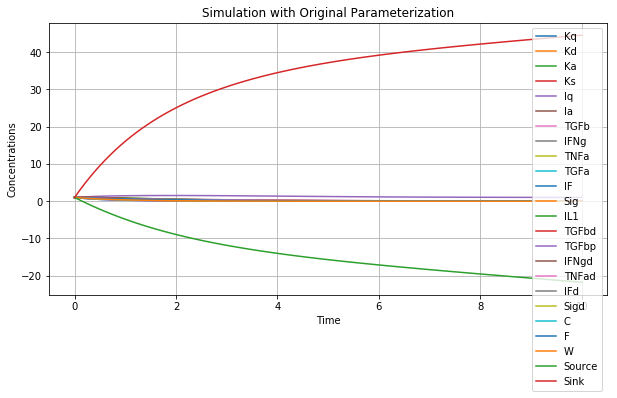

In [28]:
from temp import ode_fun
from scipy.integrate import odeint
import numpy
from matplotlib import pyplot as plt


%matplotlib inline

TVec = numpy.linspace(0,10,100)

YBase = odeint(ode_fun, SciPyModel.Species.Value, TVec, 
               args=(SciPyModel.Parameters.Value,))

plt.close()
plt.figure(figsize=(10,5))

LineObjs = plt.plot(TVec,YBase)
plt.grid()

plt.title('Simulation with Original Parameterization')
plt.xlabel('Time')
plt.ylabel('Concentrations')

plt.legend(LineObjs, SciPyModel.Species.Names)

plt.show()

Now we can exploit the nullspace to preserve the steady state condition. The module `itertools` contains a convenient function `compress` which enables the `KineticFlag` logic to be used as a scalar index.

In [29]:
import numpy, itertools

RandG = numpy.random.rand(len(NullBasis), 1)
Sample = NullSpaceFunction(
    list(
        itertools.compress(SciPyModel.Parameters.Value,
                           numpy.invert(SciPyModel.Parameters.KineticFlag))),
    SciPyModel.Species.Value).dot(RandG)

/usr/local/lib/python2.7/dist-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python2.7/dist-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


Once a sample, using the given $G$, is created, it needs to be reassembled into a proper vector alongside the shape parameters. To do so we use a temporary variable.

In [13]:
ParVec = SciPyModel.Parameters.Value[:]
counter = 0
for indx in list(
        itertools.compress(SciPyModel.Parameters.VectorIndex,
                           SciPyModel.Parameters.KineticFlag)):
    ParVec[indx] = Sample[counter,0]
    counter += 1

Hence we can now simulate the model given the kinetic parameters obtained for the desired steady state.

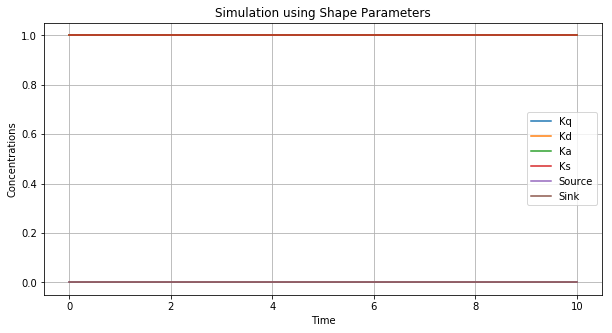

In [14]:
YAlt = odeint(ode_fun, SciPyModel.Species.Value, TVec, args=(ParVec, ))

plt.close()
plt.figure(figsize=(10, 5))

MoreObjs = plt.plot(TVec, YAlt)
plt.grid()

plt.title('Simulation using Shape Parameters')
plt.xlabel('Time')
plt.ylabel('Concentrations')

plt.legend(MoreObjs, SciPyModel.Species.Names)

plt.show()

### Notes

Currently this implementation is limited to models who are formulated as $k_A f_A(\hat{Y},\hat{E})$ since it detects the kinetic parameters by checking the index of the leftmost parameter, assuming there is one, and flagging the respective index.

As this is a deeper implementation (requiring the SBML model to pass through `importSBMLFile` and `writeODEFunction`) there should be less issues related to the original SBML format which make it through the import process.

This still needs to be written as a script in the SBML2SciPy.py file.